# Speciation
In this chapter, you will learn how to use MOAI to compute the speciation (and fractionation) of volatile elements that can exist under different forms in the atmosphere, the melt, and even solids.

## Instantaneous speciation

First, we need a MO:

In [2]:
from MO_lib.eq_basic import MO
MO.updateT_pot(3000)

No file found: calculating lookups, be patient it can take some time!


Then, we need an atmosphere (speciation is assumed to occur in the atmosphere):

In [3]:
# Atmosphere
from atmospheres import black_body
MO.atm = black_body([],               # gaseous species in the atmosphere: we will add them later
                    [],               # their partial pressures: same
                    MO.adiabat.T_pot, # Let's give it the same temperature as the MO
                    g=MO.gravity,     # the planetary radius needs to be consistent ith the MO
                    R=MO.R_out)       # se does the gravity

# we do not use the thermal evolution model, so we need to set up a parametrization to automatically update the surface temprature of the atmosphere
def update_atm_Ts(atm,T):
    atm.updateTs(T)
    return T
MO.setParametrization('update Ts',lambda var:update_atm_Ts(var['atm'],var['T_pot']),['atm','T_pot'],is_profile=False)

We will be looking at the H$_2$-H$_2$O system. Let's first add the H equivalent of one Earth water ocean:

In [4]:
from physics.constants import BSE_mass, EO_mass
from chemistry.molecules import H2O,H2,O2
MO.addSpecies([H2O,H2],
              [EO_mass/BSE_mass,0],
              volatile=True,
              reg_elems=True)

The speciation of H as either H$_2$ or H$_2$O is controlled by the redox reaction:   
$$2{\rm H}_2+{\rm O}_2=2{\rm H}_2{\rm O}$$   
At equilibrium, we can write:    
$$\frac{[{\rm H}_2{\rm O}]^2}{[{\rm H}_2]^2}=K_H(T)f_{{\rm O}_2}$$

The effective temperature of the equilibrium is $T_{\rm pot}$ which is the surface temperatue of the atmosphere. We also need to fix $f_{{\rm O}_2}$; let's assume it follows the IW buffer. We will use the right-hand side as if it was the equilibrium constant of an equilibrium between H$_2$ and H$_2$O only (O$_2$ being already accounted fo rin the right-hand-side).

In [5]:
# We set the fO2 to IW for the p,T conditions at the surface
import numpy as np
from chemistry.redox import fO2_buffers_H22
MO.setParametrization('fO2',lambda var:10**fO2_buffers_H22(var['p_sfc'],var['T_pot']),['p_sfc','T_pot'],is_profile=False)

# We update the equilibrium constant for T and fO2 at the surface
from chemistry.equilibria import eq_H
eq_H.coefs[O2] = 0 # we modify the equilibrium to ignore O2, which is included in the equilibrium constant

from chemistry.redox import equilibrium_constant_NATAF
def set_K_H(T,fO2):
    eq_H.constant = equilibrium_constant_NATAF[eq_H.expression](T) * fO2
    return eq_H.constant
MO.setParametrization('K_H',lambda var:set_K_H(var['T_pot'],var['fO2']),['T_pot','fO2'],is_profile=False) # notice that we use the parametrization for fO2 that we just added

Now that the effective equilibrium constant is fixed, we are ready to calculate the speciation

In [5]:
MO.speciation([eq_H.expression], # reodx equilibria to consider
              ['H'])             # elements whose mass is conserved
print('[H2]_liq=',MO.content['liquid']['H2'],',p_H2=',MO.atm.partial_pressure['H2'])
print('[H2O]_liq=',MO.content['liquid']['H2O'],',p_H2O=',MO.atm.partial_pressure['H2O'])

[H2]_liq= 4.227161048701982e-08 ,p_H2= 8454.322097403965
[H2O]_liq= 0.0003487927281759242 ,p_H2O= 42663.09221212394


## Speciation and crystallization
As for fractionation, we can track the speciation throughout MO crystallization. Here it is even more fun, as the equilibrium constant evolves with temperature (but actually we could also have set a $T$-dependent partition coefficient for the fractionation).   
As we already have set the update of the effective equilibrium constant using MO parametrizations (that's required to use the ubilt-in speciation function), we're all set! Everything will be automatically updated when the MO thermal state changes.

In [6]:
from tools import MO_time_series
ts = MO_time_series(MO)
ts.write(0)

# By adding H to the 'to_spec' list and the H redox equilibrium to the atmosphere equilibria list,
# we tell the MO to what to consider when calling the speciation function form the generla update
MO.atm.equilibria = [eq_H.expression]
MO.to_spec        = ['H']

while MO.p_bot > 1e9:
    MO.updateT_pot(MO.adiabat.T_pot-1) # we let the MO crystallize by decreasing its potential temperature by steps of 1 K
    ts.write(0)                        # time doesn't matter, we will use some other variable to plot the time-series

Let's see how it looks like!

Text(0, 0.5, 'pressure [Pa]')

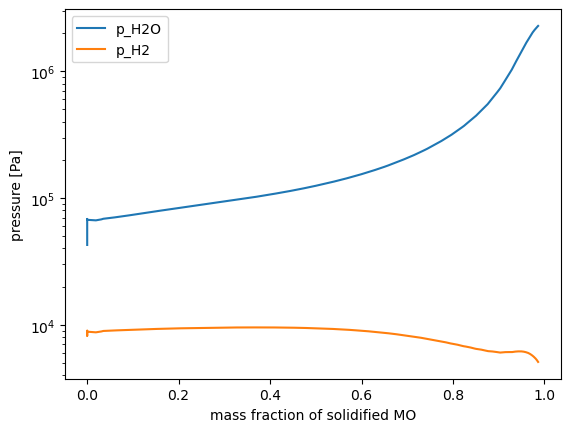

In [7]:
import matplotlib.pyplot as plt
ts.Mlogplot(['p_H2O','p_H2'])
plt.legend()
plt.xlabel('mass fraction of solidified MO')
plt.ylabel('pressure [Pa]')

## Speciation without MO
The built-in speciation function of the MO class relies on a more general function, that you may want to call directly if you don't want to bother with setting up a whole MO. For that, you will need to specify:
 - the bulk mass of each element conserved
 - the mass of solid involved in the equilibrium
 - the mass of liquid involved in the equilibrium
 - the "reduced" surface (not "reduced" in the sense of redox, it just means that it is divided by the gravity: $S_{\rm red}=4\pi R_p^2/g$)
 - the equilibrium constant of each equilibrium at play   
     
All these parameters need to be put in single dictionnary.
Let's say we want to look at the speciation/fractionation of C and H between H2O H2, CO2, CO and CH4, for a half-mantle MO at 2000 K, at IW-2, containing 1 EO mass of each element

In [40]:
T =2000 # [K]

fO2 = 10**(fO2_buffers_H22(0,T)-2) # we assume a pressure of 0, which is fine as long as we stay below the 100 MPa domain

# H2 + 1/2 O2 = H2O
eq_H.constant = equilibrium_constant_NATAF[eq_H.expression](T) * np.sqrt(fO2)

# CO + 1/2 O2 = CO2
from chemistry.equilibria import eq_C
eq_C.coefs[O2] = 0 # same trick as for the H equilibrium
eq_C.constant = equilibrium_constant_NATAF[eq_C.expression](T) * np.sqrt(fO2)

# CH4 + H2O = CO + 3H2
from chemistry.equilibria import eq_CH
eq_CH.constant = equilibrium_constant_NATAF[eq_CH.expression](T) # fO2 does not directly appear in this equilibrium

from tools import spec_iter
from physics.constants import Earth_surface_radius,Earth_gravity
from chemistry.elements import C,H
pp = spec_iter({eq_H:eq_H.constant,
                eq_C:eq_C.constant,
                eq_CH:eq_CH.constant,
                'Msol':0,
                'Mliq':BSE_mass/2,
                'Sred':4*np.pi*Earth_surface_radius**2/Earth_gravity,
                C:EO_mass,
                H:EO_mass},
               n_step=100) # number of steps for the solver: if you get a SpeciationSolverFailed error, just increase it

Let's see what we got

Text(0, 0.5, 'pressure [Pa]')

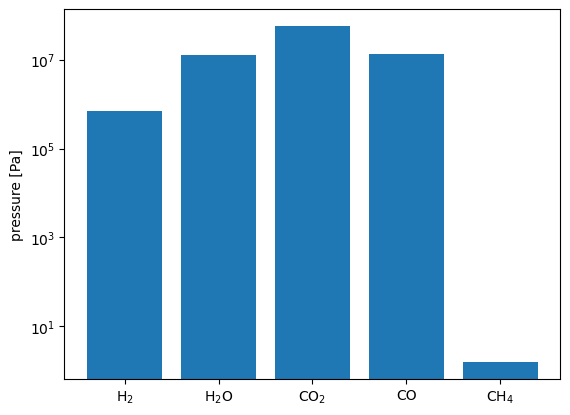

In [41]:
from chemistry.molecules import CO,CO2,CH4
plt.bar([r'H$_2$',r'H$_2$O',r'CO$_2$',r'CO',r'CH$_4$'],[pp[H2],pp[H2O],pp[CO2],pp[CO],pp[CH4]],log=True)
plt.ylabel('pressure [Pa]')